# Lotka-Volterra system with a Lawson method

> In this example we reuse previous definition in [Lotka-Voleterra resolution with Runge-Kutta method](lotka_volterra_rungekutta.ipynb) which is the first tutorial. In this notebook we solve the same example. 

The system is definied as:

$$
  \begin{aligned}
    \frac{\mathrm{d}x}{\mathrm{d}t} &= \alpha x  - \beta xy \\
    \frac{\mathrm{d}y}{\mathrm{d}t} &= \delta xy - \gamma y \\
  \end{aligned}
$$

where:

* $x$ is the number of prey
* $y$ is the number of predators
* $t$ represents time
* $\alpha$, $\beta$, $\gamma$ and $\delta$ are postive real parameters describing the interaction of the two species.

We would like to compute the invariant $V$ definied by:

$$
  V = \delta x - \gamma \ln(x) + \beta y - \alpha \ln(y)
$$

## Lawson methods

Lawson methods are a class of time integration schemes that are applied to differential equations of the form:

$$
  \dot{u} = Lu + N(t,u), \qquad u(t=0) = u_0
$$

where $L$ is a matric and $N:(t,u)\mapsto N(t,u)$ is a, in general nonlinear, function of the unknow $u$, and the time $t\geq 0$. Lawson methods are especially efficient when applied to problems where $L$ implies a stringent stability condition if it is treated explicitly. Solving this equation with a Lawson method relies of the following change of variable:
$$
  v(t) := e^{-tL}u(t)
$$
Plugging this into our equation yields
$$
  \dot{v} = e^{-tL}N(t,e^{tL}v)
$$
Now an explicit Runge-Kutta method is applied to the transformed equation. We introduce the time discretization $t^n = n\Delta t$ with $\Delta t>0$ the time step, $n\in\mathbb{N}$ and $u^n$ (respectivement $v^n$) denotes the numerical approximation of $u(t^n)$ (resp. $v(t^n)$). For the sake of simplicity, we first present the method for the explicit Euler scheme. Applying the forward Euler method to this problem leads to

$$
  v(t^n+\Delta t)\approx v^{n+1} = v^n + \Delta t e^{-t^nL}N(t^n, e^{t^nL}v^n)
$$

Reversing the change of variable $u(t) = e^{tL}v(t)$ yields the following scheme for $u^n$

$$
  u(t^n+\Delta t)\approx u^{n+1} = e^{\Delta t L}u^n + \Delta t e^{\Delta tL}N(t^n, u^n)
$$

This is the Lawson-Euler method, also a method of order one. More generally, the Lawson method induced by an explicit Runge-Kutta method RK($s$,$p$) with $s$ stages of order $p$ can be written as:

$$
  \begin{aligned}
    k_i &= e^{-c_i\Delta t L}N(t^n + c_i\Delta t, e^{c_i\Delta tL}(u^n + \Delta t\sum_{j=1}^s
a_{ij}k_j)\\
    u^{n+1} &= e^{\Delta tL}(u^n + \Delta t\sum_{i=1}^s b_ik_i)
  \end{aligned}
$$

Here, we defined the following linear and non linear part:

$$
  L = \begin{pmatrix}
      \alpha & 0 \\
      0 & -\gamma
    \end{pmatrix}, \qquad
  N:(t,u)\mapsto \begin{pmatrix}
    -\beta xy \\
    \delta xy
  \end{pmatrix}
$$

Ponio doesn't provide a general exponential function, nor a matrix data structure, so we recommend to use [Eigen](https://eigen.tuxfamily.org). In this case linear part is diagonally so we can only use a `std::valarray<double>` as other examples.

To keep $L$ and $N$ in a same object, Ponio provide a `ponio::lawson_problem`:

```cpp
state_t L = {alpha, -gamma};
auto N = [=]( double t, state_t const& un ) -> state_t {
    double x = un[0], y = un[1];
    return { -beta*x*y, delta*x*y };
};

auto pb = ponio::make_lawson_problem(L, N);
```

This problem `pb` can be use as a `ponio::simple_problem` or `ponio::problem`. If we call `ponio::solve` with a `ponio::lawson_problem` and a Lawson algorithm (same name as Runge-Kutta algorithm but prefixed by `l`) Ponio applies a Lawson method to solve the problem. Calling a Lawson algorithm neeed to provide a exponential function, here we propose a solution with overloading of exponential function for `std::valarray`.

```cpp
auto exp = [](state_t const& x)->state_t { return std::exp(x); };
ponio::solve(pb, ponio::runge_kutta::lrk_44<>(exp), u_ini, {0.,tf}, dt, "lv_demo/lv1_lawson.dat"_fobs);
```

In [1]:
%system mkdir -p lotka_volterra_lawson_demo

[]

In [2]:
%%writefile lotka_volterra_lawson_demo/main.cpp

#include <iostream>
#include <valarray>

#include "ponio/solver.hpp"
#include "ponio/observer.hpp"
#include "ponio/problem.hpp"
#include "ponio/runge_kutta.hpp"

int main()
{
    using state_t = std::valarray<double>;
    using namespace ponio::observer;

    double alpha = 2./3., beta=4./3., gamma=1., delta=1.;
    
    state_t L = { alpha, -gamma };
    auto N = [=]( double t, state_t const& u, state_t& du ) {
        double x=u[0], y=u[1];
        du[0] = -beta*x*y;
        du[1] = delta*x*y;
    };
    auto pb  = ponio::make_lawson_problem(L,N);
    
    auto exp = [](state_t const& x)->state_t { return std::exp(x); };

    double dt = 0.1;
    double tf = 100;
    state_t u_ini = {1.8,1.8};

    ponio::solve(pb, ponio::runge_kutta::lrk_44(exp), u_ini, {0.,tf}, dt, "lotka_volterra_lawson_demo/lrk_44.dat"_fobs);

    return 0;
}

Writing lotka_volterra_lawson_demo/main.cpp


In [3]:
%system $CXX -std=c++20 -I ../include lotka_volterra_lawson_demo/main.cpp -o lotka_volterra_lawson_demo/main

[]

In [4]:
%system ./lotka_volterra_lawson_demo/main

[]

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
data = np.loadtxt("lotka_volterra_lawson_demo/lrk_44.dat")
t = data[:,0]
x = data[:,1]
y = data[:,2]

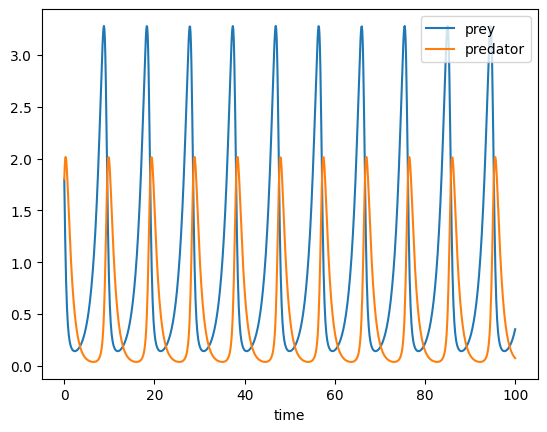

In [7]:
plt.plot(t,x,label="prey")
plt.plot(t,y,label="predator")
plt.xlabel("time")
plt.legend()
plt.show()

Now define the invariant $V$ :
    
$$
  V = \delta x - \ln(x) + \beta y - \alpha \ln(y)
$$

In [8]:
def V(x,y, alpha=2./3., beta=4./3., gamma=1., delta=1.):
    return delta*x - np.log(x) + beta*y - alpha*np.log(y)

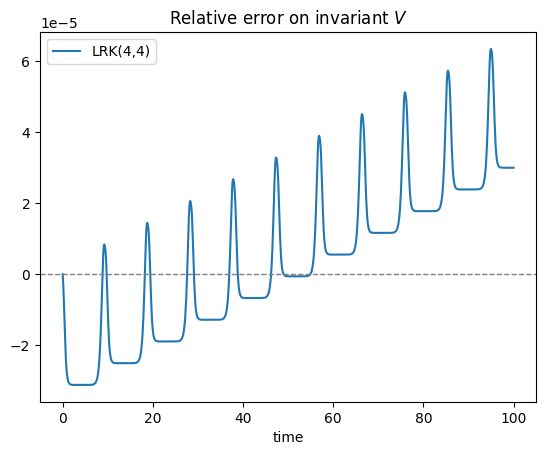

In [9]:
V0 = V(x[0],y[0])
plt.plot(t,V(x,y)/V0-1.,label="LRK(4,4)")
plt.axhline(0,0,1,linestyle="--",color="grey",linewidth=1)
plt.title("Relative error on invariant $V$")
plt.xlabel("time")
plt.legend()
plt.show()